In [96]:
import keras
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout, Input,concatenate
from keras.models import Model
from keras.optimizers import Adam,SGD
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv

from plotly.offline import init_notebook_mode
from sklearn import random_projection
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import spectral

init_notebook_mode(connected=True)
%matplotlib inline

In [97]:
## GLOBAL VARIABLES
test_ratio = 0.6

In [98]:
def loadData():
    data = np.load("Indianpine_GRPKPCA.npy") 
    labels = np.load("Indianpines_gt.npy")
    return data, labels

In [99]:
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [100]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [101]:
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [102]:
X, y = loadData()
X.shape, y.shape

((145, 145, 15), (145, 145))

In [103]:
K = X.shape[2]
K = 15
X.shape

(145, 145, 15)

In [104]:
X1, y1 = createImageCubes(X, y, windowSize=15)
print(X1.shape, y1.shape)
Xtrain1, Xtest1, ytrain1, ytest1 = splitTrainTestSet(X1, y1, test_ratio)
print(Xtrain1.shape, Xtest1.shape, ytrain1.shape, ytest1.shape)
Xtrain1, Xvalid1, ytrain1, yvalid1 = splitTrainTestSet(Xtrain1, ytrain1, 0.2)
print(Xtrain1.shape, Xvalid1.shape, ytrain1.shape, yvalid1.shape)
Xtrain1 = Xtrain1.reshape(-1,15,15, K,1)
print(Xtrain1.shape)
Xvalid1 = Xvalid1.reshape(-1,15,15, K,1)
print(Xvalid1.shape)

((10249, 15, 15, 15), (10249,))
((4099, 15, 15, 15), (6150, 15, 15, 15), (4099,), (6150,))
((3279, 15, 15, 15), (820, 15, 15, 15), (3279,), (820,))
(3279, 15, 15, 15, 1)
(820, 15, 15, 15, 1)


In [105]:
X2, y2 = createImageCubes(X, y, windowSize=13)
print(X2.shape, y2.shape)
Xtrain2, Xtest2, ytrain2, ytest2 = splitTrainTestSet(X2, y2, test_ratio)
print(Xtrain2.shape, Xtest2.shape, ytrain2.shape, ytest2.shape)
Xtrain2, Xvalid2, ytrain2, yvalid2 = splitTrainTestSet(Xtrain2, ytrain2, 0.2)
print(Xtrain2.shape, Xvalid2.shape, ytrain2.shape, yvalid2.shape)
Xtrain2 = Xtrain2.reshape(-1,13,13, K,1)
print(Xtrain2.shape)
Xvalid2 = Xvalid2.reshape(-1,13,13, K,1)
print(Xvalid2.shape)

((10249, 13, 13, 15), (10249,))
((4099, 13, 13, 15), (6150, 13, 13, 15), (4099,), (6150,))
((3279, 13, 13, 15), (820, 13, 13, 15), (3279,), (820,))
(3279, 13, 13, 15, 1)
(820, 13, 13, 15, 1)


In [106]:
X3, y3 = createImageCubes(X, y, windowSize=11)
print(X3.shape, y3.shape)
Xtrain3, Xtest3, ytrain3, ytest3 = splitTrainTestSet(X3, y3, test_ratio)
print(Xtrain3.shape, Xtest3.shape, ytrain3.shape, ytest3.shape)
Xtrain3, Xvalid3, ytrain3, yvalid3 = splitTrainTestSet(Xtrain3, ytrain3, 0.2)
print(Xtrain3.shape, Xvalid3.shape, ytrain3.shape, yvalid3.shape)
Xtrain3 = Xtrain3.reshape(-1,11,11, K,1)
print(Xtrain3.shape)
Xvalid3 = Xvalid3.reshape(-1,11,11, K,1)
print(Xvalid3.shape)

((10249, 11, 11, 15), (10249,))
((4099, 11, 11, 15), (6150, 11, 11, 15), (4099,), (6150,))
((3279, 11, 11, 15), (820, 11, 11, 15), (3279,), (820,))
(3279, 11, 11, 15, 1)
(820, 11, 11, 15, 1)


In [107]:
X4, y4 = createImageCubes(X, y, windowSize=9)
print(X4.shape, y4.shape)
Xtrain4, Xtest4, ytrain4, ytest4 = splitTrainTestSet(X4, y4, test_ratio)
print(Xtrain4.shape, Xtest4.shape, ytrain4.shape, ytest4.shape)
Xtrain4, Xvalid4, ytrain4, yvalid4 = splitTrainTestSet(Xtrain4, ytrain4, 0.2)
print(Xtrain4.shape, Xvalid4.shape, ytrain4.shape, yvalid4.shape)
Xtrain4 = Xtrain4.reshape(-1,9,9, K)
print(Xtrain4.shape)
Xvalid4 = Xvalid4.reshape(-1,9,9, K)
print(Xvalid4.shape)

((10249, 9, 9, 15), (10249,))
((4099, 9, 9, 15), (6150, 9, 9, 15), (4099,), (6150,))
((3279, 9, 9, 15), (820, 9, 9, 15), (3279,), (820,))
(3279, 9, 9, 15)
(820, 9, 9, 15)


X5, y5 = createImageCubes(X, y, windowSize=13)
print(X5.shape, y5.shape)
Xtrain5, Xtest5, ytrain5, ytest5 = splitTrainTestSet(X5, y5, test_ratio)
print(Xtrain5.shape, Xtest5.shape, ytrain5.shape, ytest5.shape)
Xtrain5, Xvalid5, ytrain5, yvalid5 = splitTrainTestSet(Xtrain5, ytrain5, 0.4)
print(Xtrain5.shape, Xvalid5.shape, ytrain5.shape, yvalid5.shape)
Xtrain5 = Xtrain5.reshape(-1,13,13,K)
print(Xtrain5.shape)
Xvalid5 = Xvalid5.reshape(-1,13,13,K)
print(Xvalid5.shape)
ytrain5 = np_utils.to_categorical(ytrain5,num_classes=16)
print(ytrain5.shape)
yvalid5 = np_utils.to_categorical(yvalid5)
print(yvalid5.shape)

In [108]:
inputA=Input((15,15,15,1))
c11=Conv3D(filters=32, kernel_size=(3,3,7), activation='relu')(inputA)
#c11=BatchNormalization()(c11)
c12=Conv3D(filters=64, kernel_size=(3,3,5), activation='relu')(c11)
#c12=BatchNormalization()(c12)
c13=Conv3D(filters=128, kernel_size=(3,3,3), activation='relu')(c12)
c13_shape = c13._keras_shape
f1=Reshape((c13_shape [1], c13_shape [2], c13_shape [3]*c13_shape[4]),name='op1')(c13)
model_a = Model(inputs=inputA, outputs=f1)  
model_a.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 15, 15, 15, 1)     0         
_________________________________________________________________
conv3d_37 (Conv3D)           (None, 13, 13, 9, 32)     2048      
_________________________________________________________________
conv3d_38 (Conv3D)           (None, 11, 11, 5, 64)     92224     
_________________________________________________________________
conv3d_39 (Conv3D)           (None, 9, 9, 3, 128)      221312    
_________________________________________________________________
op1 (Reshape)                (None, 9, 9, 384)         0         
Total params: 315,584
Trainable params: 315,584
Non-trainable params: 0
_________________________________________________________________


In [109]:
inputB=Input((13,13,15,1))
c21=Conv3D(filters=32, kernel_size=(3,3,7), activation='relu')(inputB)
#c21=BatchNormalization()(c21)
c22=Conv3D(filters=64, kernel_size=(3,3,5), activation='relu')(c21)
#c22=BatchNormalization()(c22)
c23=Conv3D(filters=128, kernel_size=(1,1,3), activation='relu')(c22)
c23_shape = c23._keras_shape
f2=Reshape((c23_shape [1], c23_shape [2], c23_shape [3]*c23_shape[4]),name='op2')(c23)
model_b = Model(inputs=inputB, outputs=f2)  
model_b.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 13, 13, 15, 1)     0         
_________________________________________________________________
conv3d_40 (Conv3D)           (None, 11, 11, 9, 32)     2048      
_________________________________________________________________
conv3d_41 (Conv3D)           (None, 9, 9, 5, 64)       92224     
_________________________________________________________________
conv3d_42 (Conv3D)           (None, 9, 9, 3, 128)      24704     
_________________________________________________________________
op2 (Reshape)                (None, 9, 9, 384)         0         
Total params: 118,976
Trainable params: 118,976
Non-trainable params: 0
_________________________________________________________________


In [110]:
inputC=Input((11,11,15,1))
c31=Conv3D(filters=32, kernel_size=(3,3,7), activation='relu')(inputC)
#c31=BatchNormalization()(c31)
c32=Conv3D(filters=64, kernel_size=(1,1,5), activation='relu')(c31)
#c32=BatchNormalization()(c32)
c33=Conv3D(filters=128, kernel_size=(1,1,3), activation='relu')(c32)
c33_shape = c33._keras_shape
f3=Reshape((c33_shape [1], c33_shape [2], c33_shape [3]*c33_shape[4]),name='op3')(c33)
model_c = Model(inputs=inputC, outputs=f3)  
model_c.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 11, 11, 15, 1)     0         
_________________________________________________________________
conv3d_43 (Conv3D)           (None, 9, 9, 9, 32)       2048      
_________________________________________________________________
conv3d_44 (Conv3D)           (None, 9, 9, 5, 64)       10304     
_________________________________________________________________
conv3d_45 (Conv3D)           (None, 9, 9, 3, 128)      24704     
_________________________________________________________________
op3 (Reshape)                (None, 9, 9, 384)         0         
Total params: 37,056
Trainable params: 37,056
Non-trainable params: 0
_________________________________________________________________


inputD=Input((13,13,15,1))
c41=Conv3D(filters=16, kernel_size=(3,3,7), activation='relu')(inputD)
c42=Conv3D(filters=32, kernel_size=(5,5,5), activation='relu')(c41)
c43=Conv3D(filters=64, kernel_size=(7,7,3), activation='relu')(c42)
c43_shape = c43._keras_shape
f4=Reshape((c43_shape [1], c43_shape [2], c43_shape [3]*c43_shape[4]),name='op4')(c43)
model_d = Model(inputs=inputD, outputs=f4)  
model_d.summary()

In [111]:
ip_from_a = model_a.get_layer("op1").output
ip_from_b = model_b.get_layer("op2").output
ip_from_c = model_c.get_layer("op3").output
#ip_from_d = model_d.get_layer("op4").output
#Feature_ip= concatenate([ip_from_a,ip_from_b,ip_from_c,ip_from_d])
#print(Feature_ip.shape)

In [112]:
inputE=Input((9,9,15))
Feature_ip1= concatenate([ip_from_a,ip_from_b,ip_from_c,inputE])
conv_layer1=Conv2D(filters=64, kernel_size=(5,5), activation='relu')(Feature_ip1)
conv_layer2 = Conv2D(filters=128,kernel_size=(3,3), activation='relu')(conv_layer1)
flatten_layer = Flatten()(conv_layer2)
dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
#dense_layer1=BatchNormalization()(dense_layer1)
dense_layer1 = Dropout(0.2)(dense_layer1)
dense_layer2 = Dense(units=128, activation='relu')(flatten_layer)
#dense_layer2=BatchNormalization()(dense_layer2)
dense_layer2 = Dropout(0.2)(dense_layer2)
output_layer = Dense(units=16, activation='softmax')(dense_layer2)
model_e = Model(inputs=[model_a.input,model_b.input,model_c.input,inputE], outputs=output_layer)
model_e.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 15, 15, 15, 1 0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           (None, 13, 13, 15, 1 0                                            
__________________________________________________________________________________________________
input_19 (InputLayer)           (None, 11, 11, 15, 1 0                                            
__________________________________________________________________________________________________
conv3d_37 (Conv3D)              (None, 13, 13, 9, 32 2048        input_17[0][0]                   
__________________________________________________________________________________________________
conv3d_40 

In [113]:
# compiling the model
adam = Adam(lr=0.001, decay=1e-06)
model_e.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [114]:
filepath = "PropM5Test.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
earlyStopping=  EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
callbacks_list = [checkpoint]

In [115]:
ytrain4 = np_utils.to_categorical(ytrain4,num_classes=16)
print(ytrain4.shape)
yvalid4 = np_utils.to_categorical(yvalid4,num_classes=16)
print(yvalid4.shape)

(3279, 16)
(820, 16)


In [116]:
import time
start = time.time()
history = model_e.fit(x=[Xtrain1,Xtrain2,Xtrain3,Xtrain4], y=ytrain4, batch_size=200, epochs=50, callbacks=callbacks_list,validation_data=([Xvalid1,Xvalid2,Xvalid3,Xvalid4],yvalid4))
end = time.time()
print(end - start)

Train on 3279 samples, validate on 820 samples
Epoch 1/50
3279/3279 [==============================] - 22s 7ms/step - loss: 2.1872 - acc: 0.2745 - val_loss: 1.5832 - val_acc: 0.4134

Epoch 00001: acc improved from -inf to 0.27447, saving model to PropM5Test.hdf5
Epoch 2/50
3279/3279 [==============================] - 20s 6ms/step - loss: 1.4705 - acc: 0.4681 - val_loss: 1.1077 - val_acc: 0.5488

Epoch 00002: acc improved from 0.27447 to 0.46813, saving model to PropM5Test.hdf5
Epoch 3/50
3279/3279 [==============================] - 21s 6ms/step - loss: 1.0246 - acc: 0.6136 - val_loss: 0.7511 - val_acc: 0.7159

Epoch 00003: acc improved from 0.46813 to 0.61360, saving model to PropM5Test.hdf5
Epoch 4/50
3279/3279 [==============================] - 21s 6ms/step - loss: 0.6817 - acc: 0.7435 - val_loss: 0.4629 - val_acc: 0.8280

Epoch 00004: acc improved from 0.61360 to 0.74352, saving model to PropM5Test.hdf5
Epoch 5/50
3279/3279 [==============================] - 20s 6ms/step - loss: 0.4

3279/3279 [==============================] - 20s 6ms/step - loss: 0.0151 - acc: 0.9948 - val_loss: 0.0412 - val_acc: 0.9915

Epoch 00042: acc did not improve from 0.99909
Epoch 43/50
3279/3279 [==============================] - 21s 6ms/step - loss: 0.0098 - acc: 0.9966 - val_loss: 0.0409 - val_acc: 0.9854

Epoch 00043: acc did not improve from 0.99909
Epoch 44/50
3279/3279 [==============================] - 20s 6ms/step - loss: 0.0223 - acc: 0.9945 - val_loss: 0.0954 - val_acc: 0.9793

Epoch 00044: acc did not improve from 0.99909
Epoch 45/50
3279/3279 [==============================] - 20s 6ms/step - loss: 0.0146 - acc: 0.9957 - val_loss: 0.0473 - val_acc: 0.9866

Epoch 00045: acc did not improve from 0.99909
Epoch 46/50
3279/3279 [==============================] - 20s 6ms/step - loss: 0.0138 - acc: 0.9960 - val_loss: 0.0568 - val_acc: 0.9878

Epoch 00046: acc did not improve from 0.99909
Epoch 47/50
3279/3279 [==============================] - 20s 6ms/step - loss: 0.0070 - acc: 0.997

In [117]:
tot_time=end-start
print("Total Elapsed Runtime:",str(int((tot_time/3600)))+":"+str(int((tot_time%3600)/60))+":"+str(int((tot_time%3600)%60)) )

('Total Elapsed Runtime:', '0:17:5')


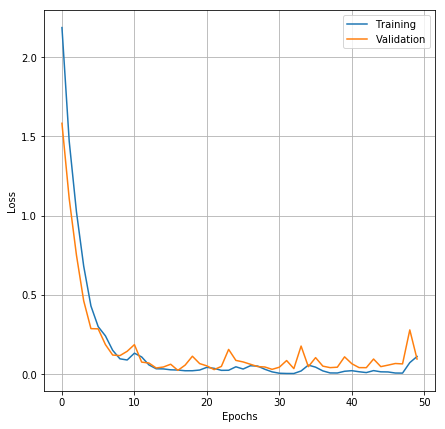

In [118]:
plt.figure(figsize=(7,7))
plt.grid()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training','Validation'], loc='upper right')
plt.savefig("proM(eq)_loss.png")
plt.show()

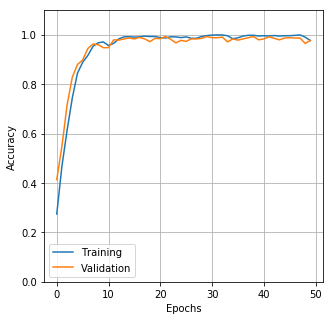

In [119]:
plt.figure(figsize=(5,5))
plt.ylim(0,1.1)
plt.grid()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training','Validation'])
plt.savefig("propM5(eq)_acc.png")
plt.show()

In [ ]:
# load best weights
model_e.load_weights("PropM5.hdf5")
model_e.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [ ]:
Xtest1 = Xtest1.reshape(-1,15,15,K,1)
print(Xtest1.shape)
Xtest2 = Xtest2.reshape(-1,13,13,K,1)
print(Xtest2.shape)
Xtest3 = Xtest3.reshape(-1,11,11,K,1)
print(Xtest3.shape)
Xtest4 = Xtest4.reshape(-1,9,9,K)
print(Xtest4.shape)
#Xtest5 = Xtest5.reshape(-1,13,13,K)
#print(Xtest5.shape)

In [22]:
ytest1 = np_utils.to_categorical(ytest1)
print(ytest1.shape)
ytest2 = np_utils.to_categorical(ytest2)
print(ytest2.shape)
ytest3 = np_utils.to_categorical(ytest3)
print(ytest3.shape)
ytest4 = np_utils.to_categorical(ytest4)
print(ytest4.shape)
#ytest5 = np_utils.to_categorical(ytest5)
#print(ytest5.shape)

(4100, 16)
(4100, 16)
(4100, 16)
(4100, 16)


In [23]:
Y_pred_test = model_e.predict([Xtest1,Xtest2,Xtest3,Xtest4])
y_pred_test = np.argmax(Y_pred_test, axis=1)
classification = classification_report(np.argmax(ytest4, axis=1), y_pred_test)
print(classification)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       0.99      0.99      0.99       571
           2       1.00      1.00      1.00       332
           3       1.00      1.00      1.00        95
           4       0.99      0.99      0.99       193
           5       1.00      1.00      1.00       292
           6       1.00      1.00      1.00        11
           7       0.99      1.00      1.00       191
           8       1.00      1.00      1.00         8
           9       1.00      0.99      1.00       389
          10       1.00      0.99      1.00       982
          11       0.99      1.00      0.99       237
          12       1.00      1.00      1.00        82
          13       1.00      1.00      1.00       506
          14       0.99      1.00      1.00       155
          15       1.00      1.00      1.00        37

   micro avg       1.00      1.00      1.00      4100
   macro avg       1.00   

In [24]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [25]:
def reports (X_test,y_test):
    #start = time.time()
    Y_pred = model_e.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    #end = time.time()
    #print(end - start)
    
    target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']   
    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model_e.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    
    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

In [28]:
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports([Xtest1,Xtest2,Xtest3,Xtest4],ytest4)
classification = str(classification)
confusion = str(confusion)
file_name = "prop_M5.txt"

with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

4100/4100 [==============================] - 8s 2ms/step


In [29]:
def Patch(data,height_index,width_index,PATCH_SIZE):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    
    return patch

In [30]:
# load the original image
X, y = loadData()

In [31]:
height = y.shape[0]
width = y.shape[1]
#PATCH_SIZE = [25,23,21,19,13]
numComponents = K

In [32]:
X1 = padWithZeros(X, 15//2)
X2 = padWithZeros(X, 13//2)
X3 = padWithZeros(X, 11//2)
X4 = padWithZeros(X, 9//2)
#X5 = padWithZeros(X, 13//2)

In [33]:
# calculate the predicted image
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        target = int(y[i,j])
        if target == 0 :
            continue
        else :
            image_patch1=Patch(X1,i,j,15)
            X_test_image1 = image_patch1.reshape(1,image_patch1.shape[0],image_patch1.shape[1], image_patch1.shape[2],1).astype('float32')
            image_patch2=Patch(X2,i,j,13)
            X_test_image2 = image_patch2.reshape(1,image_patch2.shape[0],image_patch2.shape[1], image_patch2.shape[2],1).astype('float32')
            image_patch3=Patch(X3,i,j,11)
            X_test_image3 = image_patch3.reshape(1,image_patch3.shape[0],image_patch3.shape[1], image_patch3.shape[2],1).astype('float32')
            image_patch4=Patch(X4,i,j,9)
            X_test_image4 = image_patch4.reshape(1,image_patch4.shape[0],image_patch4.shape[1], image_patch4.shape[2]).astype('float32')
            #image_patch5=Patch(X5,i,j,13)
            #X_test_image5 = image_patch5.reshape(1,image_patch5.shape[0],image_patch5.shape[1], image_patch5.shape[2]).astype('float32')                                   
            prediction = (model_e.predict([X_test_image1,X_test_image2,X_test_image3,X_test_image4]))
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1

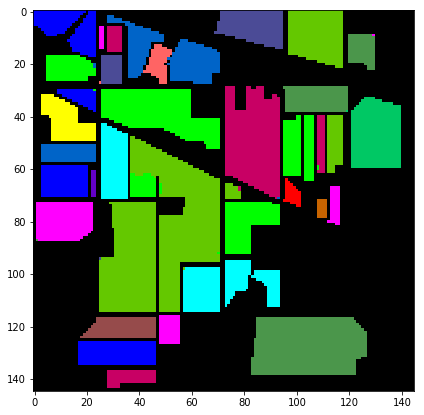

In [34]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))

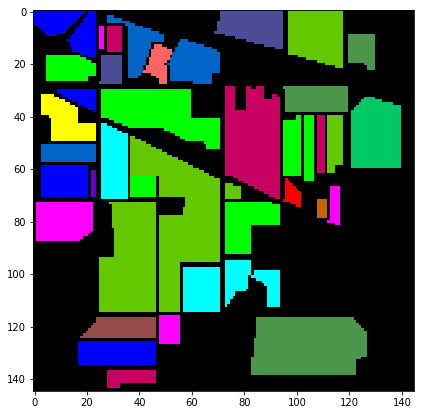

In [35]:
gt= spectral.imshow(classes =y,figsize =(7,7))

In [36]:
spectral.save_rgb("IP_predictions5.jpg", outputs.astype(int), colors=spectral.spy_colors)